# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   SilkOptimalEpsilon, 
                   QuantileEpsilon)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
import pandas as pd
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# 1.0 Plot the data

Let's plot the experimental data

[ 0  2  4  6 16 18 20 22 24]


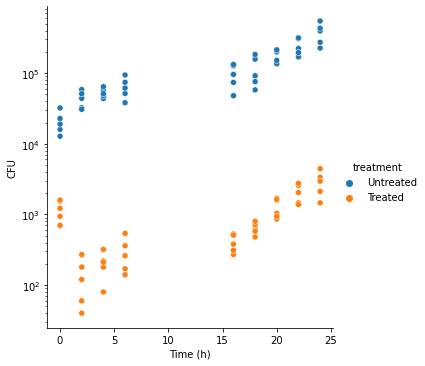

In [78]:
#Could use PlotNine which is like ggplot2 
#Import gerba.data.20200302.csv
gerba_data = pd.read_csv('../Data/gerba.data.20200302.csv')
#unique times
times = gerba_data.time.unique()
print(times)

#using seaborn plot conc vs time and colour by treatment on log scale
g=sns.relplot(x='time', y='conc', hue='treatment', data=gerba_data)
g.set(yscale="log")
_ = g.set(xlabel="Time (h)", ylabel="CFU")

# Define the ODE to solve 

1) We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ y'=(1-\dfrac{y}{C})r-d\exp(-g t)y$$

$C$ is carrying capacity. $d$ is maximum effecicacy. $g$ is decay from the disinfectant. $r$ recontamination from contacts (this is linear). $l$ is the proliferation rate on the hands.

2) If we wanted to consider proliferation on hands instead of surface accrual then we could use:
$$ y'=y(1-\dfrac{y}{C})l-d\exp(-g t)y$$

where $l$ is the rate at which microorganisms proliferate on hands. E.g. reproduction.

3) Proliferation and increase from contacts can be combined:
$$ y'=(yl+r)(1-\dfrac{y}{C})-d\exp(-g t)y$$

But since we don't see any saturation then we could ignore carrying capacity. 
$$ y'=(yl+r)(1-y)-d\exp(-g t)y$$

However with the data we have it is unlikely that we can learn about $l$ and $r$ together.

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-

Notes: 12th April
- We can first try to fit the model to the data from group 2's washed hand to learn only about $C$ and $r$.
- Then with those learned $C$ and $r$ we can fit the model to the data from group 1's washed hand to learn only about $d$ and $g$. 
- But we never reach a saturation so maybe we shouldn't consider $C$ at all.


Notes: 13th April 2022
- Try to take into account untreated data from group 1 to estimate the effect of proliferation and accrual
- Apply $ y'=(yl+r)(1-y)$ to untreated hand from group 1 to learn about $l$ (proliferation rate) and $r$ (surface contact rate).
- Ideally we use all data from both groups to learn about all the parametrs because we can assume that the untreated hand from both groups behaves similarly. Fitting an exponential model to these data, suggests $l$ (proliferation) is the same for both groups (0.18)
$$ y'=yl-d\exp(-g t)y$$

Notes: 29th Dec 2022
- Added curve-fit to estimate $d$ and $g$

- Changed the epsilon from fixed to QuantileEpsilon 
- "from pyabc import ... SilkOptimalEpsilon, QuantileEpsilon"
- eps=QuantileEpsilon(alpha=0.4)
- h = abc.run( max_nr_populations=15) 

Notes: 2nd Jan 2023
- Fitted $$ y'=yl-d\exp(-g t)y$$ instead of logistic growth curve
- used PCMAD distance in AdatpiveNorm Distance 

from pyabc.populationstrategy import AdaptivePopulationSize

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,
)

abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=1000,#AdaptivePopulationSize(500, 0.15),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),

## 1.1 Curve fit to find a range for d and g
Fit an exponential curve  $d e^{-g t}$ to $0-6h$ for the Treated datasets as we assume that the effect from disinfection is dominant at this stage

[1200  134  202  294] [385.22720569  93.7016542   86.13942187 162.11107303]
[0 2 4 6]


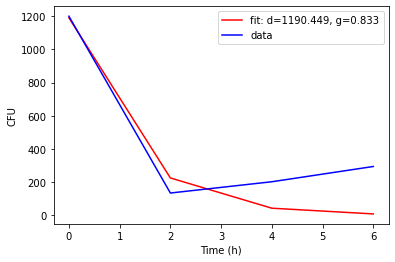

In [104]:
#Import experimental data (gerba.data.20200302.csv) from Data
gerba_data = pd.read_csv("../Data/gerba.data.20200302.csv")

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, b, g):
    return b * np.exp(-g * x) 

#Filter data to only include treated samples and from time 16 to 24
gerba_data = gerba_data[(gerba_data['treatment'] == 'Treated') & (gerba_data['time'] >= 0) & (gerba_data['time'] <= 6)]

y = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).mean()
s = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).std()

print(y.values,s.values)
xdata = np.array(gerba_data['time'].unique())
print(xdata)
popt, pcov = curve_fit(func, xdata, y)

plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: d=%5.3f, g=%5.3f' % tuple(popt))
# Plot the data
plt.plot(xdata, y, 'b-', label='data')
plt.xlabel('Time (h)')
plt.ylabel('CFU')
plt.legend()
plt.show()


The untreated group grows exponentially throughout but we use the last 6h to estimate the accrual rate from contacts using the function:

$$ y'=yl-d\exp(-g t)y$$

which has solution:

$$y(t)=\ln(k)e^{lt}e^{e^{-gt}}$$

$$ y = C_1\exp(lt - \frac{d}{g}\exp(-g t)) $$



/Users/marcofking/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1.         0.24777154 1.44603453 0.28761814]


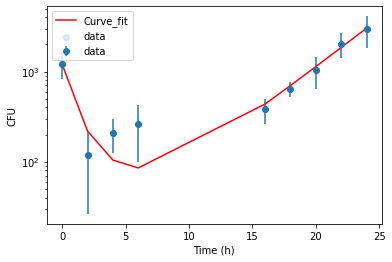

In [263]:


import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def model(t, y, l,  d, g):
    y = 1200*np.exp(l*t + (d*np.exp(-g*t))/g)*np.exp(-d/g)#np.exp(l*t - d/g*np.exp(-g*t))# C*y-d*np.exp(-g*t)*y#y*(1 - y/C)*r - d*np.exp(-g*t)*y
    return y

#Import experimental data (gerba.data.20200302.csv) from Data
gerba_data = pd.read_csv("../Data/gerba.data.20200302.csv")

#Filter data to only include treated samples and from time 16 to 24
gerba_data = gerba_data[(gerba_data['treatment'] == 'Treated') & (gerba_data['time'] >= 0) & (gerba_data['time'] <= 24)]



# Define the independent and dependent variables
t = np.array(gerba_data['time'].unique()) # Replace "..." with your time data
y = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).median() 
s = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).std()

# Define the initial estimates for the parameters
C0 = 10000 #  initial estimate for C
r0 = 50 #  initial estimate for r
d0 = 5 #  initial estimate for d
g0 = 0.3 # initial estimate for g

#model(t,y,C0,r0,d0,g0)


# Fit the model to the data using curve_fit
popt, pcov = curve_fit(model, t, y)

# The optimal values for the parameters are stored in popt
#C_opt, r_opt, d_opt, g_opt = popt
print(popt)
plt.plot(t,model(t,*popt),'r-',label="Curve_fit")
#plt.plot(t, model(t, *popt), 'r-', label='fit: C=%5.3f, d=%5.3f, g=%5.3f, r=%5.3f' % tuple(popt))
# Plot the data using scatter plot gerba_data[gerba_data['treatment'] == 'Treated']['time'] against gerba_data[gerba_data['treatment'] == 'Treated']['conc']
plt.scatter(t, y, label='data',alpha=0.15)
plt.errorbar(t, y, yerr=s, fmt='o', label='data')
plt.xlabel('Time (h)')
plt.ylabel('CFU')
plt.yscale('log')
plt.legend()
plt.show()


## 3.0 ABC-SMC setup

## Define ODE to Solve

In [337]:
# our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0])#np.array([134.0,202.0,294.0,400,644,1232,2044,2868])

s=np.array([94,86,162])#np.array([94,86,162,117,124,397,629,1147])

measurement_times = np.array([2,4,6])#t#np.array([2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

#Here we define the ODE model (1)- we use inferred parameter ranges from lienar regression r=0.18, d=1146, g=1.18, C=unknown
def ode_model(contamination,t,C,d,g):
    Contamination = contamination
    return ( C * Contamination  -  d * np.exp(-g * t) *Contamination) #(r * (1 - Contamination/C) * Contamination  - d * math.exp(-g * t) *Contamination) #
#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":np.concatenate([num_at_2,num_at_4,num_at_6])}# + 0*np.random.randn(3)}

In [280]:
print(deterministic_run({"C":0.17,"d":45,"g":18}),
#0.17180078 45.5818535  17.99749254]
measurement_data)

{'Contamination': array([138.37131968, 194.41767232, 273.16521664])} [134. 202. 294.]


# Define the parameter priors

We use the curve_fit attempt above to provide some representative paramter ranges:  [C=0.17180078, d=45.5818535, g=17.99749254]]

From using $y'=l*y-d exp(-g*t)$, C=RV("uniform", 0, 10), d=RV("uniform", 0, 50),g=RV("uniform", 0, 50)

In [338]:
parameter_prior = Distribution(C=RV("uniform", 0, 10),
                               #r=RV("uniform", 1e-2, 1e2),
                               d=RV("uniform", 0, 50),
                               g=RV("uniform", 0, 50))

parameter_prior.get_parameter_names()

['C', 'd', 'g']

# Define the distance function
This currently is a absolute distances between the two points divided by the standard deviation at each point. Could use Manhattan distance.

In [272]:
def distance(simulation, data):
    return np.absolute(((data["Contamination"]) - (simulation["Contamination"]))).sum() #L1 norm
    #return  ((data["Contamination"]) - (simulation["Contamination"])**2).sum()
    #L2 norm
    #return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum() #L1 norm with sd

# Set up the ABC SMC 


In [107]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [339]:
# We plug all the ABC options together
#Using adaptive population size and local transition
#eps = pyabc.AdaptiveEpsilon(0.001, decay=0.1, limit=0.1)
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)

from pyabc.populationstrategy import AdaptivePopulationSize

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,
)

abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=1000,#AdaptivePopulationSize(500, 0.15),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
    #eps=QuantileEpsilon(alpha=0.4)
    #transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

Here we define the initial conditions as well as the observed lab data. 
All ten participants washed their hands for 1 minute with soft soap and then used a paper towel to dry their hands. Participants were then asked to rub their fingertips and thumb for 1 minute.
 time_0 refers to immediatelly after hand hygiene so in reality this might be 5 or 10 minutes after.

In [115]:
#Import experimental data (gerba.data.20200302.csv) from Data
#gerba_data = pd.read_csv("../Data/gerba.data.20200302.csv")

#Find mean and standard deviation for each time and treatment type 

#gerba_data_mean = gerba_data.groupby(['time','treatment']).mean()
#gerba_data_sd = gerba_data.groupby(['time','treatment']).std()

#Filter gerba_data_mean and gerba_data_sd to only include time=2,4,6 and treatment="Treatment"
#gerba_data_mean = gerba_data_mean.loc[(gerba_data_mean.index.get_level_values('time').isin([0,2,4,6])) & (gerba_data_mean.index.get_level_values('treatment').isin(["Treated"]))]
#gerba_data_mean

,,Unnamed: 0,conc,id
time,treatment,,,
0,Treated,48,1200,3
2,Treated,53,134,3
4,Treated,58,202,3
6,Treated,63,294,3


In [340]:
#This sets up the database and includes the measurement data and standard deviation
history = abc.new(db_path, {"Contamination": measurement_data}) #,"sd":s

ABC.History INFO: Start <ABCSMC id=44, start_time=2023-01-02 21:22:36>


# Running the ABC

In [341]:
# We run the ABC until either criterion is met
history = abc.run(max_nr_populations=15)

ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.98540921e+00.
ABC INFO: Accepted: 1000 / 1940 = 5.1546e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 4.01016443e-03.
ABC INFO: Accepted: 1000 / 2228 = 4.4883e-01, ESS: 8.7907e+02.
ABC INFO: t: 2, eps: 3.14960166e-02.
ABC INFO: Accepted: 1000 / 2211 = 4.5228e-01, ESS: 4.9787e+02.
ABC INFO: t: 3, eps: 1.64180927e-01.
ABC INFO: Accepted: 1000 / 2752 = 3.6337e-01, ESS: 1.9753e+02.
ABC INFO: t: 4, eps: 1.03896157e-01.
ABC INFO: Accepted: 1000 / 3523 = 2.8385e-01, ESS: 5.1150e+02.
ABC INFO: t: 5, eps: 3.04078563e-01.
ABC INFO: Accepted: 1000 / 3664 = 2.7293e-01, ESS: 6.2946e+02.
ABC.Distance INFO: Too many high-bias values, correcting only for scale.
ABC INFO: t: 6, eps: 1.68461845e+01.
ABC INFO: Accepted: 1000 / 3180 = 3.1447e-01, ESS: 8.3751e+02.
ABC.Distance INFO: Features ['Contamination:0'] (ixs=[0]) have a high bias.
ABC INFO: t: 7, eps: 9.64927654e-01.
ABC INFO: Accept

# Visualise the probability density functions


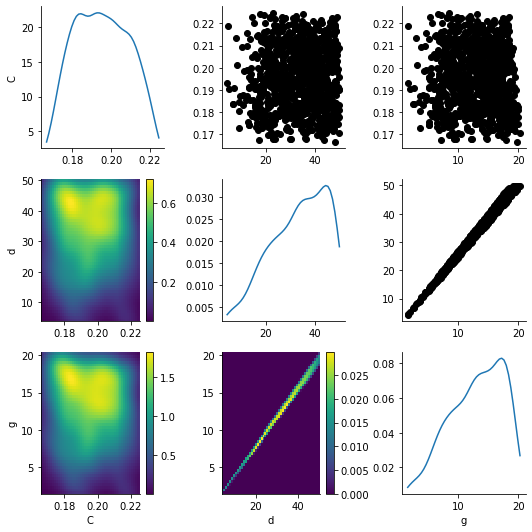

In [342]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

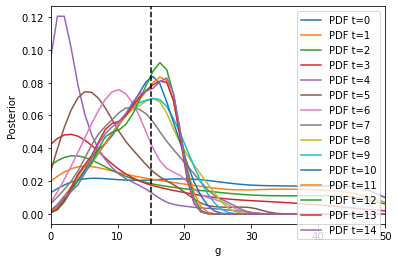

In [343]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=50,
        x="g",
        # xname=r"$\lambda$",
        ax=ax,
        label=f"PDF t={t}",
    )
#Add a vertical line at lambda=0.49 +- 0.32 to 0.72 
#This is the experimental value predicted in King et al. 2020 with Kalanne
ax.axvline(15, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [344]:
df.to_csv("../Data/abc_results.csv", encoding='utf-8', index=False)
df.describe()

name,C,d,g
count,1000.000000,1000.000000,1000.000000
mean,0.195835,33.558387,13.047310
std,0.013789,10.096543,3.940636
min,0.166619,4.297137,1.677590
25%,0.184261,26.134185,10.104714
50%,0.195700,34.593261,13.363203
75%,0.207087,41.964418,16.314739
max,0.224721,49.984519,20.245920


# Plot some trajectories


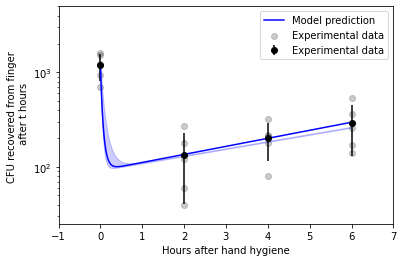

In [345]:
import pandas as pd
import operator


#plot some curves from the ODE model
precision=5000
tmax = 6
time_space = np.linspace(0,tmax,precision+1)#precision+1?

P=odeint(ode_model,initial_contamination,time_space,args=(df["C"].mean(),df["d"].mean(),df["g"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["C"].quantile(0.05),df["d"].quantile(0.05),df["g"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["C"].quantile(0.05),df["d"].quantile(0.95),df["g"].quantile(0.95)))

#P=ode_model({"af":df["af"].mean(),"cs":df["cs"].mean(),"lam":df["lam"].mean()})
#Pmin=ode_model({"af":df["af"].quantile(0.05),"cs":df["cs"].quantile(0.05),"lam":df["lam"].quantile(0.05)})
#Pmax=ode_model({"af":df["af"].quantile(0.95),"cs":df["cs"].quantile(0.95),"lam":df["lam"].quantile(0.95)})

# create a vector of values between 0 and 6
x = np.array([0,2,4,6])

#Define new sd just for plotting to avoid SD value at 0

#Plot errobars of experimental data
#x = np.array([0,2,4,6,16,18,20,22,24])

# include value 100 at the beginning of the vector to avoid SD value at 0 by concatenating
gerba_data = gerba_data[(gerba_data['treatment'] == 'Treated') & (gerba_data['time'] >= 0) & (gerba_data['time'] <= 6)]

y = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).mean()
s = gerba_data[gerba_data['treatment'] == 'Treated']['conc'].groupby(gerba_data['time']).std()
#scatter plot of gerba data
plt.scatter(gerba_data['time'],gerba_data['conc'],label='Experimental data',color='black',alpha=0.2)
plt.errorbar(x,y,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction

plt.fill_between(time_space,np.concatenate(Pmin),np.concatenate(Pmax),alpha=0.2,color='blue')
#plt.plot(time_space,Pmin,label="Model prediction",color='red')
#plt.plot(time_space,Pmax,label="Model prediction",color='red')

#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,7)
plt.ylim(0.25e2,0.5e4)
plt.ylabel("CFU recovered from finger \n after t hours")
plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.legend(loc="upper right")
#make y axis logarithmic


#save the plot
plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()

In [220]:
measurement_data 

array([134., 202., 294.])